In [2]:
import numpy as np
import csv

def read_csv(path):
  width = 34
  height = 26
  dims = 1

  with open(path,'r') as f:
    #read the scv file with the dictionary format
    reader = csv.DictReader(f)
    rows = list(reader)

  #imgs is a numpy array with all the images
  #tgs is a numpy array with the tags of the images
  imgs = np.empty((len(list(rows)),height,width, dims),dtype=np.uint8)
  tgs = np.empty((len(list(rows)),1))

  for row,i in zip(rows,range(len(rows))):
    #convert the list back to the image format
    img = row['image']
    img = img.strip('[').strip(']').split(', ')
    im = np.array(img,dtype=np.uint8)
    im = im.reshape((height, width))
    im = np.expand_dims(im, axis=2)
    imgs[i] = im

    #the tag for open is 1 and for close is 0
    tag = row['state']
    if tag == 'open':
      tgs[i] = 1
    else:
      tgs[i] = 0

  #shuffle the dataset
  index = np.random.permutation(imgs.shape[0])
  imgs = imgs[index]
  tgs = tgs[index]

  #return images and their respective tags
  return imgs, tgs

In [3]:
import matplotlib.pyplot as plt
import os, glob, cv2, random
import seaborn as sns
import pandas as pd

In [5]:
X, y = read_csv(os.path.join('/content/dataset.csv'))

print(X.shape, y.shape)

(2874, 26, 34, 1) (2874, 1)


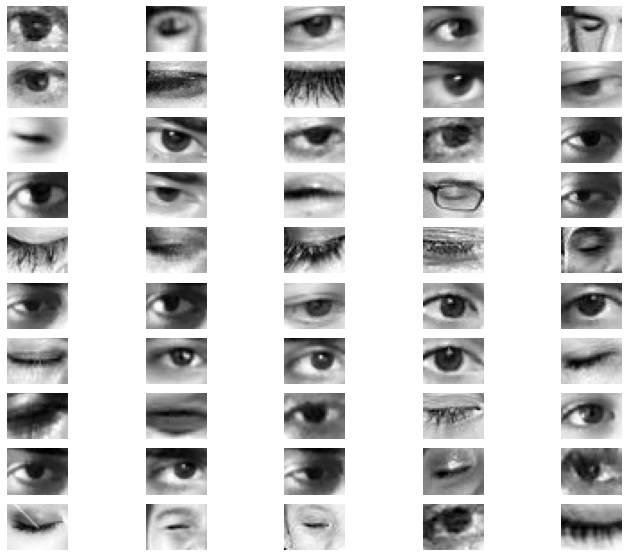

In [6]:
# 내가 봤을때 왼쪽 눈
plt.figure(figsize=(12, 10))
for i in range(50):
    plt.subplot(10, 5, i+1)
    plt.axis('off')
    plt.imshow(X[i].reshape((26, 34)), cmap='gray')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


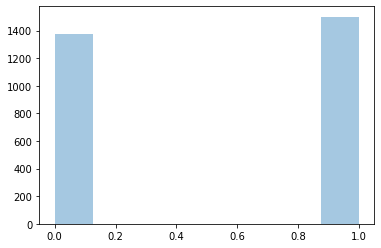

In [7]:
sns.distplot(y, kde=False)

## Preprocessing

In [8]:
n_total = len(X)
X_result = np.empty((n_total, 26, 34, 1))

for i, x in enumerate(X):
    img = x.reshape((26, 34, 1))
    
    X_result[i] = img

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_result, y, test_size=0.1)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_val.npy', x_val)
np.save('y_val.npy', y_val)

(2586, 26, 34, 1) (2586, 1)
(288, 26, 34, 1) (288, 1)


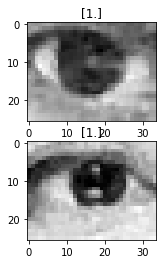

In [10]:
plt.subplot(2, 1, 1)
plt.title(str(y_train[0]))
plt.imshow(x_train[0].reshape((26, 34)), cmap='gray')
plt.subplot(2, 1, 2)
plt.title(str(y_val[4]))
plt.imshow(x_val[4].reshape((26, 34)), cmap='gray')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


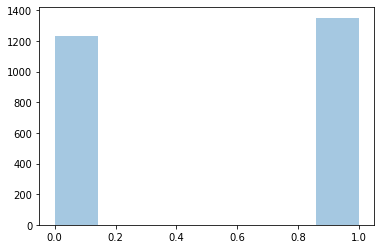

In [11]:
sns.distplot(y_train, kde=False)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


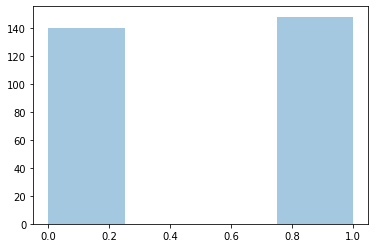

In [12]:
sns.distplot(y_val, kde=False)

## Train

In [13]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
plt.style.use('dark_background')

In [15]:
x_train = np.load('/content/x_train.npy').astype(np.float32)
y_train = np.load('/content/y_train.npy').astype(np.float32)
x_val = np.load('/content/x_val.npy').astype(np.float32)
y_val = np.load('/content/y_val.npy').astype(np.float32)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2586, 26, 34, 1) (2586, 1)
(288, 26, 34, 1) (288, 1)


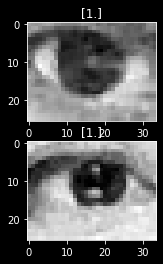

In [16]:
plt.subplot(2, 1, 1)
plt.title(str(y_train[0]))
plt.imshow(x_train[0].reshape((26, 34)), cmap='gray')
plt.subplot(2, 1, 2)
plt.title(str(y_val[4]))
plt.imshow(x_val[4].reshape((26, 34)), cmap='gray')

In [17]:
#Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

In [18]:
#Build Model
inputs = Input(shape=(26, 34, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 34, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 34, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 17, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 17, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 8, 128)         73856 

In [19]:
#train
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    train_generator, epochs=50, validation_data=val_generator,
    callbacks=[
        ModelCheckpoint('models/%s.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


81/81 [==============================] - ETA: 0s - loss: 0.4823 - acc: 0.7734
Epoch 1: val_acc improved from -inf to 0.91319, saving model to models/2022_03_23_08_24_41.h5
81/81 [==============================] - 8s 89ms/step - loss: 0.4823 - acc: 0.7734 - val_loss: 0.2795 - val_acc: 0.9132 - lr: 0.0010
Epoch 2/50
81/81 [==============================] - ETA: 0s - loss: 0.2591 - acc: 0.8991
Epoch 2: val_acc improved from 0.91319 to 0.96181, saving model to models/2022_03_23_08_24_41.h5
81/81 [==============================] - 6s 70ms/step - loss: 0.2591 - acc: 0.8991 - val_loss: 0.1185 - val_acc: 0.9618 - lr: 0.0010
Epoch 3/50
81/81 [==============================] - ETA: 0s - loss: 0.1647 - acc: 0.9412
Epoch 3: val_acc improved from 0.96181 to 0.97917, saving model to models/2022_03_23_08_24_41.h5
81/81 [==============================] - 6s 70ms/step - loss: 0.1647 - acc: 0.9412 - val_loss: 0.0555 - val_acc: 0.9792 - lr: 0.0010
Epoch 4/50
81/81 [==============================] - ETA: 

test acc: 1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


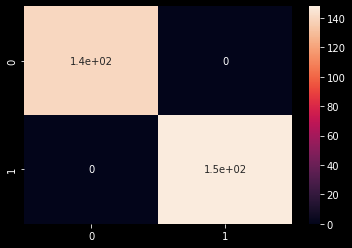

In [20]:
#Confusion Matrix
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

model = load_model('models/%s.h5' % (start_time))

y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred > 0.5).astype(np.int)

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)

## Test

In [21]:
!pip install cmake

In [22]:
!pip install imutils

In [23]:
import cv2

In [26]:
import cv2, dlib
import numpy as np
from imutils import face_utils
from keras.models import load_model

IMG_SIZE = (34, 26)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

model = load_model('models/2022_03_23_08_24_41.h5')
model.summary()

def crop_eye(img, eye_points):
  x1, y1 = np.amin(eye_points, axis=0)
  x2, y2 = np.amax(eye_points, axis=0)
  cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

  w = (x2 - x1) * 1.2
  h = w * IMG_SIZE[1] / IMG_SIZE[0]

  margin_x, margin_y = w / 2, h / 2

  min_x, min_y = int(cx - margin_x), int(cy - margin_y)
  max_x, max_y = int(cx + margin_x), int(cy + margin_y)

  eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)

  eye_img = gray[eye_rect[1]:eye_rect[3], eye_rect[0]:eye_rect[2]]

  return eye_img, eye_rect

# main
cap = cv2.VideoCapture(0)

while cap.isOpened():
  ret, img_ori = cap.read()

  if not ret:
    break

  img_ori = cv2.resize(img_ori, dsize=(0, 0), fx=0.5, fy=0.5)

  img = img_ori.copy()
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = detector(gray)

  for face in faces:
    shapes = predictor(gray, face)
    shapes = face_utils.shape_to_np(shapes)

    eye_img_l, eye_rect_l = crop_eye(gray, eye_points=shapes[36:42])
    eye_img_r, eye_rect_r = crop_eye(gray, eye_points=shapes[42:48])

    eye_img_l = cv2.resize(eye_img_l, dsize=IMG_SIZE)
    eye_img_r = cv2.resize(eye_img_r, dsize=IMG_SIZE)
    eye_img_r = cv2.flip(eye_img_r, flipCode=1)

    cv2.imshow('l', eye_img_l)
    cv2.imshow('r', eye_img_r)

    eye_input_l = eye_img_l.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.
    eye_input_r = eye_img_r.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.

    pred_l = model.predict(eye_input_l)
    pred_r = model.predict(eye_input_r)

    # visualize
    state_l = 'O %.1f' if pred_l > 0.1 else '- %.1f'
    state_r = 'O %.1f' if pred_r > 0.1 else '- %.1f'

    state_l = state_l % pred_l
    state_r = state_r % pred_r

    cv2.rectangle(img, pt1=tuple(eye_rect_l[0:2]), pt2=tuple(eye_rect_l[2:4]), color=(255,0,0), thickness=2)
    cv2.rectangle(img, pt1=tuple(eye_rect_r[0:2]), pt2=tuple(eye_rect_r[2:4]), color=(255,0,0), thickness=2)

    cv2.putText(img, state_l, tuple(eye_rect_l[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    cv2.putText(img, state_r, tuple(eye_rect_r[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

  cv2.imshow('result', img)
  if (cv2.waitKey(1) == '27'):
    break
    


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 34, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 34, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 17, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 17, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 8, 128)         73856 

In [29]:
import cv2
import dlib
import numpy as np
from scipy.spatial import distance as dist
# import winsound
import time

video_capture = cv2.VideoCapture(0)
face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

right_eye_points = list(range(36, 42))
left_eye_points = list(range(42, 48))

count_ar = 0
left_ar = 30*[] 
right_ar = 30*[]

eye_ratio_limit = 0.00

count_time = 0
count_time2 = 0

eye_cap = False
eye_open_done = True
program_switch = False
message_popup = False
print_counter = 0
txt_switch = False
txt_switch2 = False
alarm = False

face_alarm = False
face_reco = False

face_reco = False
face_reco_n = True
face = 0
fnd_count = 0

open_eye = True

def eye_ratio(eyepoint):
    A = dist.euclidean(eyepoint[1],eyepoint[5])
    B = dist.euclidean(eyepoint[2],eyepoint[4])
    C = dist.euclidean(eyepoint[0],eyepoint[3])
    ER = (A+B) / (2.0*C)

    return ER

def rotate (brx,bry):
    crx = brx - midx
    cry = bry - midy
    arx = np.cos(-angle)*crx - np.sin(-angle)*cry
    ary = np.sin(-angle)*crx + np.cos(-angle)*cry
    rx = int (arx + midx)
    ry = int (ary + midy)

    return(rx,ry)

while True:
    ret, frame = video_capture.read()
    flip_frame = cv2.flip(frame,1)
    gray = cv2.cvtColor(flip_frame, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_image = clahe.apply(gray)
    detection = face_detector(clahe_image)

    key = cv2.waitKey(10) & 0xFF

    if message_popup == True:
        if print_counter == 0:
            cv2.putText(flip_frame, '', (230, 450), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        if print_counter == 1:
            cv2.putText(flip_frame, 'Try again', (260, 450), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        if print_counter == 2:
            cv2.putText(flip_frame, 'Gaze the camera', (230, 450), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        if print_counter == 3:
            cv2.putText(flip_frame, 'Program starts in : 3', (200, 450), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        if print_counter == 4:
            cv2.putText(flip_frame, 'Program starts in : 2', (200, 450), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        if print_counter == 5:
            cv2.putText(flip_frame, 'Program starts in : 1', (200, 450), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        if print_counter == 6:
            cv2.putText(flip_frame, 'CALCULATING', (240, 450), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    if key == ord('p'):
        if not eye_cap == True:
            eye_open_done = False
        else :
            eye_open_done = True
            eye_cap = False
            cv2.destroyWindow('image2')
            program_switch = False
            eye_ratio_limit = 0.00
            left_ar = [0,] 
            right_ar = [0,]

    count_ar = 0
    winsound.PlaySound(None, winsound.SND_ASYNC)
    txt_switch = False
    alarm = False

    if eye_open_done == False:
        for fd in detection:
            eye_open_shape = shape_predictor(clahe_image, fd)
            eye_open_landmarks = np.matrix([[p.x, p.y] for p in eye_open_shape.parts()])
            eye_open_left_eye = eye_open_landmarks[left_eye_points] 
            eye_open_right_eye = eye_open_landmarks[right_eye_points] 
            eye_open_ER_left = eye_ratio(eye_open_left_eye)
            eye_open_ER_right = eye_ratio(eye_open_right_eye)

    if(count_ar < 100):
        count_ar += 1

    for i in range(36,41):
        cv2.line(flip_frame,(eye_open_shape.part(i).x, eye_open_shape.part(i).y),(eye_open_shape.part(i+1).x, eye_open_shape.part(i+1).y),(255,0,0),1)
        cv2.line(flip_frame,(eye_open_shape.part(41).x, eye_open_shape.part(41).y),(eye_open_shape.part(36).x, eye_open_shape.part(36).y),(255,0,0),1)
    for i in range(42,47):
        cv2.line(flip_frame,(eye_open_shape.part(i).x, eye_open_shape.part(i).y),(eye_open_shape.part(i+1).x, eye_open_shape.part(i+1).y),(255,0,0),1)
        cv2.line(flip_frame,(eye_open_shape.part(47).x, eye_open_shape.part(47).y),(eye_open_shape.part(42).x, eye_open_shape.part(42).y),(255,0,0),1)
        print_counter = 2
        message_popup = True
    if(30<count_ar<=60):
        left_ar.append(eye_open_ER_left)
        right_ar.append(eye_open_ER_right)
        print_counter = 6
    if(60<count_ar<=70):
        print_counter = 0
        Max_ER_left = max(left_ar)
        Max_ER_right = max(right_ar)
        eye_ratio_limit = (Max_ER_left + Max_ER_right)/2*0.65
    if(70<count_ar<=80):
        print_counter = 3
    if(80<count_ar<=90):
        print_counter = 4
    if(90<count_ar<100):
        print_counter = 5

    if(count_ar == 100):
        eye_open_done = True
        eye_cap = True
        program_switch = True
        print_counter = 0
        count_ar = 0
        count_time = time.time()

    if program_switch == True:
        face_reco = False
        face_reco_n = True
    for d in detection:

        face_reco = True
        fnd_count = 0
        count_time2 = time.time()

    if txt_switch2 == True:
        winsound.PlaySound(None, winsound.SND_ASYNC)
        face_alarm = False
        txt_switch2 = False

    x = d.left()
    y = d.top()
    x1 = d.right()
    y1 = d.bottom()
    bdx = x-(x1-x)/2
    bdy = y-(y1-y)/2
    bdx1 = x1+(x1-x)/2
    bdy1 = y1+(y1-y)/2
    midx = (x+x1)/2
    midy = (y+y1)/2

    shape = shape_predictor(clahe_image, d)

    rex = shape.part(45).x
    rey = shape.part(45).y
    lex = shape.part(36).x
    ley = shape.part(36).y

    mex = int (lex + (rex-lex)/2)
    mey = int (ley + (rey-ley)/2)

    tanx = mex - lex
    tany = ley - mey
    tan = tany/tanx
    angle = np.arctan(tan)
    degree = np.degrees(angle)

    rsd_1 = rotate(x,y)
    rsd_2 = rotate(x1,y)
    rsd_3 = rotate(x,y1)
    rsd_4 = rotate(x1,y1)
    d2_1 = rotate(bdx,bdy)
    d2_2 = rotate(bdx1,bdy)
    d2_3 = rotate(bdx,bdy1)
    d2_4 = rotate(bdx1,bdy1)

    pts1 = np.float32([[d2_1[0],d2_1[1]],[d2_2[0],d2_2[1]],[d2_3[0],d2_3[1]],[d2_4[0],d2_4[1]]])
    pts2 = np.float32([[0,0],[400,0],[0,400],[400,400]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(flip_frame,M,(400,400))

    d2gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    d2clahe_image = clahe.apply(d2gray)
    d2detections = face_detector(d2clahe_image)

    for d2 in d2detections:
        xx = d2.left()
        yy = d2.top()
        xx1 = d2.right()
        yy1 = d2.bottom()
        d2shape = shape_predictor(d2clahe_image, d2)

    cv2.rectangle(dst, (xx, yy), (xx1, yy1), (0, 255, 255), 1)
    for i in range(1,68):
        circle.circle(dst, (d2shape.part(i).x, d2shape.part(i).y), 1, (255,0,255), thickness=1)
    for i in range(36,41):
        cv2.line(dst,(d2shape.part(i).x, d2shape.part(i).y),(d2shape.part(i+1).x, d2shape.part(i+1).y),(255,0,0),1)
        cv2.line(dst,(d2shape.part(41).x, d2shape.part(41).y),(d2shape.part(36).x, d2shape.part(36).y),(255,0,0),1)
    for i in range(42,47):
        cv2.line(dst,(d2shape.part(i).x, d2shape.part(i).y),(d2shape.part(i+1).x, d2shape.part(i+1).y),(255,0,0),1)
        cv2.line(dst,(d2shape.part(47).x, d2shape.part(47).y),(d2shape.part(42).x, d2shape.part(42).y),(255,0,0),1)
        landmarks = np.matrix([[p.x, p.y] for p in d2shape.parts()])
        right_eye = landmarks[left_eye_points] 
        left_eye = landmarks[right_eye_points] 
        ER_right = eye_ratio(right_eye)
        ER_left = eye_ratio(left_eye)

    if ER_left <= eye_ratio_limit and ER_right <= eye_ratio_limit:
        open_eye = False

    if ER_left > eye_ratio_limit and ER_right > eye_ratio_limit:
        open_eye = True

    if open_eye == True:
        count_time = time.time()

    cv2.line(flip_frame,rsd_1,rsd_2,(100,255,100),1)
    cv2.line(flip_frame,rsd_1,rsd_3,(100,255,100),1)
    cv2.line(flip_frame,rsd_4,rsd_2,(100,255,100),1)
    cv2.line(flip_frame,rsd_4,rsd_3,(100,255,100),1)

    for i in range(0,67):
        cv2.circle(flip_frame, (shape.part(i).x, shape.part(i).y), 1, (0,0,255), thickness=1)
    for i in range(36,41):
        cv2.line(flip_frame,(shape.part(i).x, shape.part(i).y),(shape.part(i+1).x, shape.part(i+1).y),(255,0,0),1)
        cv2.line(flip_frame,(shape.part(41).x, shape.part(41).y),(shape.part(36).x, shape.part(36).y),(255,0,0),1)
    for i in range(42,47):
        cv2.line(flip_frame,(shape.part(i).x, shape.part(i).y),(shape.part(i+1).x, shape.part(i+1).y),(255,0,0),1)
        cv2.line(flip_frame,(shape.part(47).x, shape.part(47).y),(shape.part(42).x, shape.part(42).y),(255,0,0),1)
        cv2.putText(flip_frame, 'Left : {:.2f}'.format(ER_left), (450, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 200, 200), 2)
        cv2.putText(flip_frame, 'Right : {:.2f}'.format(ER_right), (450, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 200, 200), 2)
        cv2.putText(flip_frame, 'Degree : {:.2f}'.format(degree), (450, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 200, 200), 2)
        cv2.putText(flip_frame, 'Eye ratio limit: {:.2f}'.format(eye_ratio_limit), (10, 430), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    if time.time()-count_time > 2.5:
        txt_switch = True

    if alarm == False:
        winsound.PlaySound('school_alarm.wav', winsound.SND_LOOP + winsound.SND_ASYNC)
        print('alarm on')
        alarm = True

    if face_reco == False:
        face_reco_n = False
        fnd_count += 1
    if fnd_count >= 10:
        cv2.putText(dst, 'FACE NOT DETECTED', (100, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(flip_frame, 'FACE NOT DETECTED', (10, 460), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        count_time = time.time()

    if txt_switch == False and time.time()-count_time2 > 4.5:
        txt_switch2 = True
    if txt_switch2 == True:
        cv2.putText(flip_frame, 'NO FACE ALARM!!!', (10, 60),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    if face_alarm == False:
        winsound.PlaySound('school_alarm.wav', winsound.SND_LOOP + winsound.SND_ASYNC)
        print('face alarm on')
        face_alarm = True

    if face_reco == True and face_reco_n == True:
        face = 2
    if face_reco == False and face_reco_n == False:
        face = 1
    if face_reco == False and face_reco_n == True:
        face = 0

    if txt_switch == True:
        cv2.putText(flip_frame, 'ALARM!!!', (10, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.imshow('image2', dst)

    if face == 2 and key == ord('s'):

        txt_switch = False
        alarm = False
        winsound.PlaySound(None, winsound.SND_ASYNC)
        cv2.imshow('Frame', flip_frame)
        print('time = ',time.time()-count_time)
        print("time2 = ",time.time()-count_time2)
        print('face = ',face)

    if key == ord('q'):
        eye_ratio_limit = 0.00
        winsound.PlaySound(None, winsound.SND_ASYNC)
    break
cv2.destroyAllWindows()
video_capture.release()

error: ignored